In [1]:
#https://github.com/pomber/covid19
import numpy as np
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt
import datetime

In [2]:
df = pd.read_csv('../data/brazil_corona19_data.csv', sep=',')
df['date'] = df['date'].astype('datetime64[ns]')

today = str(df.date.max().date())
tomorrow = str(df.date.max().date() + datetime.timedelta(days=1))
dayAfterTomorrow = str(df.date.max().date() + datetime.timedelta(days=2))
yesterday = str(df.date.max().date() - datetime.timedelta(days=1))

df[df['state']=='SP'].tail()

,region,state,date,case_day,cases,death_day,deaths,day,%var_case_day,%var_death_day,avg7_cases,avg7_deaths,perc_death,avg7_perc_death
694,Sudeste,SP,2020-04-13,140,8895,20,608,48,-58.33,-28.57,575.0,43.0,6.84,6.62
695,Sudeste,SP,2020-04-14,476,9371,87,695,49,240.00,335.00,527.0,46.0,7.42,6.74
696,Sudeste,SP,2020-04-15,1672,11043,83,778,50,251.26,-4.60,619.0,50.0,7.05,6.84
697,Sudeste,SP,2020-04-16,525,11568,75,853,51,-68.60,-9.64,584.0,51.0,7.37,6.95
698,Sudeste,SP,2020-04-17,1273,12841,75,928,52,142.48,0.00,660.0,55.0,7.23,7.04


In [3]:
states = df['state'].unique()
states

array(['RO', 'AC', 'AM', 'RR', 'PA', 'AP', 'TO', 'MA', 'PI', 'CE', 'RN',
       'PB', 'PE', 'AL', 'SE', 'BA', 'MG', 'ES', 'RJ', 'SP', 'PR', 'SC',
       'RS', 'MS', 'MT', 'GO', 'DF'], dtype=object)

----------------------------
### Predicting cases and deaths for a selected stated

In [4]:
#inform the states for predictions
predictedStates = ['PI', 'CE', 'MG', 'RJ', 'SP', 'PR',]

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


,state,ds,case_day,death_day,cases,deaths,predicted?
32,PR,2020-04-13,18,1,756,31,False
33,PR,2020-04-14,35,5,791,36,False
34,PR,2020-04-15,12,2,803,38,False
35,PR,2020-04-16,29,3,832,41,False
36,PR,2020-04-17,42,1,874,42,False
37,PR,2020-04-18,58,2,932,44,True
38,PR,2020-04-19,53,3,985,47,True
39,PR,2020-04-20,38,2,1023,49,True
40,PR,2020-04-21,51,3,1074,52,True
41,PR,2020-04-22,51,2,1125,54,True


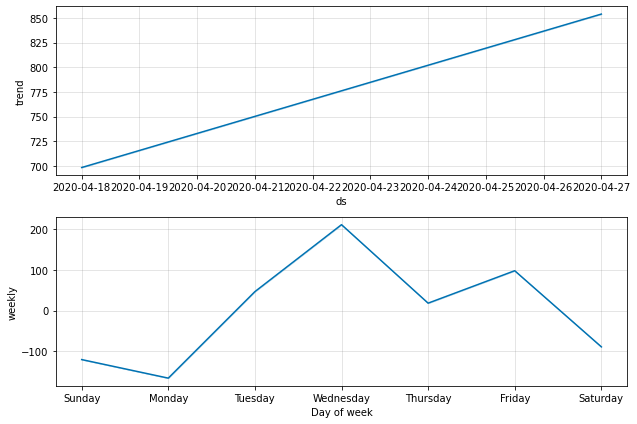

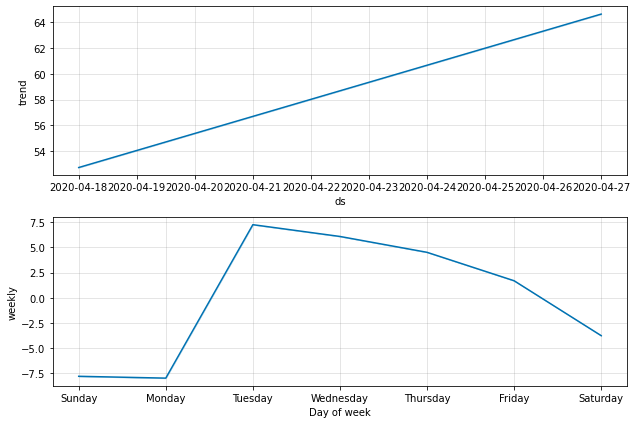

In [5]:
df_prediction = pd.DataFrame(columns=['state','ds', 'case_day', 'death_day', 'cases', 'deaths'])
daysToPredict = 10

for state in predictedStates:
    # preparing dataset for predictions
    df_state = df.loc[df['state'] == state][['date','state','case_day','death_day']]
    df_state.rename(columns={'date': 'ds'}, inplace= True)
    df_cases = df_state.loc[:,['ds','case_day']]
    df_cases.rename(columns={'case_day':'y'}, inplace =True)

    df_deaths = df_state.loc[:,['ds','death_day']]
    df_deaths.rename(columns={'death_day':'y'}, inplace =True)
    
    # fiting the model and making prediction
    m_cases = Prophet(yearly_seasonality=False, daily_seasonality=False, interval_width=0.95, growth='linear')
    m_cases.fit(df_cases)
    m_deaths = Prophet(yearly_seasonality=False, daily_seasonality=False, interval_width=0.95, growth='linear')
    m_deaths.fit(df_deaths)
    
    future_cases = m_cases.make_future_dataframe(periods=daysToPredict, freq='D', include_history=False)
    future_deaths = m_deaths.make_future_dataframe(periods=daysToPredict, freq='D', include_history=False)
    
    forecast_cases = m_cases.predict(future_cases)
    forecast_deaths = m_deaths.predict(future_deaths)
    if state == 'SP':
        fig = m_cases.plot_components(forecast_cases)
        fig.savefig('../predictions/saoPaulo_prophet_cases.png')
        fig = m_deaths.plot_components(forecast_deaths)
        fig.savefig('../predictions/saoPaulo_prophet_deaths.png')
        
    p = forecast_cases.loc[:,['ds','yhat']]
    p.rename(columns={'yhat': 'y'}, inplace= True)
    t = df_cases.append(p[['ds','y']], ignore_index=True)
    
    p = forecast_deaths.loc[:,['ds','yhat']]
    p.rename(columns={'yhat': 'y'}, inplace= True)
    s = df_deaths.append(p[['ds','y']], ignore_index=True)

    t['ds'] = t['ds'].astype('datetime64[ns]')
    t.rename(columns={'y': 'case_day'}, inplace= True)
    t['case_day'] = t['case_day'].astype('int32')
    t['cases'] = t['case_day'].cumsum().astype('int32')
    t['death_day'] = s['y'].astype('int32')
    t['deaths'] = t['death_day'].cumsum().astype('int32')
    t['state'] = state
    t['predicted?'] = t['ds'] > today # para separar o que é previsão (True) do que é dado real (False)
    df_prediction = df_prediction.append(t)
    
df_prediction.to_csv('../predictions/brazilPredicion_' + today + '.csv', index = False)
df_prediction.tail(15)

In [6]:
df_prediction.loc[df_prediction['ds']==tomorrow]

,state,ds,case_day,death_day,cases,deaths,predicted?
29,PI,2020-04-18,6,0,108,8,True
32,CE,2020-04-18,175,11,2859,160,True
41,MG,2020-04-18,51,1,1072,36,True
44,RJ,2020-04-18,249,21,4598,362,True
52,SP,2020-04-18,609,48,13450,976,True
37,PR,2020-04-18,58,2,932,44,True


In [7]:
df_prediction.loc[df_prediction['ds']==dayAfterTomorrow]

,state,ds,case_day,death_day,cases,deaths,predicted?
30,PI,2020-04-19,7,0,115,8,True
33,CE,2020-04-19,178,11,3037,171,True
42,MG,2020-04-19,68,2,1140,38,True
45,RJ,2020-04-19,267,21,4865,383,True
53,SP,2020-04-19,595,46,14045,1022,True
38,PR,2020-04-19,53,3,985,47,True


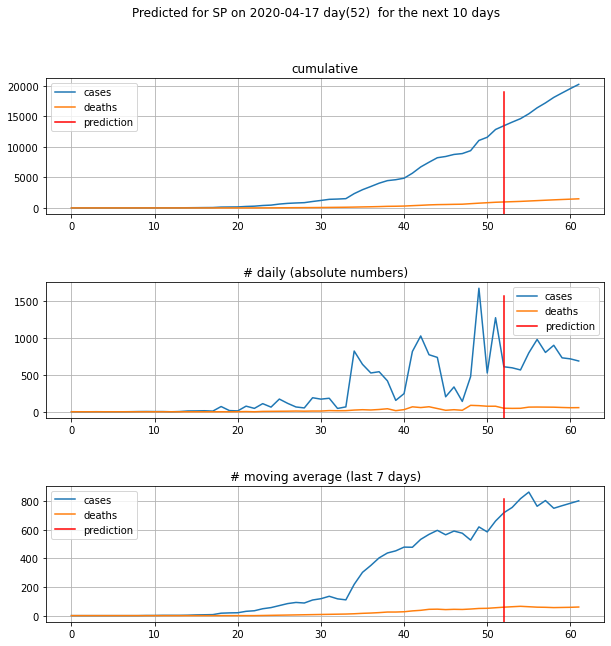

In [8]:
df_br = df_prediction.loc[df_prediction['state']=='SP']
df_br.reset_index(0, inplace=True)

x = df_br.index
corte = df_br.loc[df_br.ds == str(today)].index[0]+1

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,10))
fig.suptitle('Predicted for ' + df_br.state[0] + ' on ' + today + ' day('+ str(corte) +') ' + ' for the next ' + str(daysToPredict) + ' days')
fig.subplots_adjust(hspace = 0.5)
ax1.set_title('cumulative')
ax1.plot(x, df_br['cases'], label = 'cases')#, linewidths = 0.01)
ax1.plot(x, df_br['deaths'], label = 'deaths')
ax1.grid()
ax1.axvline(x=corte, ymin=0, ymax=0.9, color = 'red', label = 'prediction')
ax1.legend()

ax2.set_title('# daily (absolute numbers)')
ax2.plot(x, df_br['case_day'], label = 'cases')
ax2.plot(x, df_br['death_day'], label = 'deaths')
ax2.grid()
ax2.axvline(x=corte, ymin=0, ymax=0.9, color = 'red', label = 'prediction')
ax2.legend()

avg7_cases_million = df_br['case_day'].rolling(window=7).mean().replace([np.inf, -np.inf], 0).replace([np.nan], 0).astype('int')
avg7_death_million = df_br['death_day'].rolling(window=7).mean().replace([np.inf, -np.inf], 0).replace([np.nan], 0).astype('int')

ax3.set_title('# moving average (last 7 days)')
ax3.plot(x, avg7_cases_million, label = 'cases')
ax3.plot(x, avg7_death_million, label = 'deaths')
ax3.grid()
ax3.axvline(x=corte, ymin=0, ymax=0.9, color = 'red', label = 'prediction')
ax3.legend()

plt.savefig('../predictions/saoPaulo_predictions.png')

### Generating the markdown file

In [9]:
f = open('../predictions/README.md', 'w')

readme = '# **Predições**\n'
readme += "Para experiência, estou fazendo predições simples sobre a quantidade de casos e mortes diárias. Como são séries temporais (*time-series*), estou usando [Facebook Prophet](https://facebook.github.io/prophet/docs/quick_start.html) que também é desenhado para este tipo de predição de uma maneira bem mais simples. "
readme += "Isso funciona muito bem na maioria das vezes; porém, algumas vezes há um grande salto entre os números que impactam no desempenho do modelo e leva um tempo (medições) para ser absorvido e compreendidos.\n\n"
readme += 'Essas predições foram feitas com os dados da pandemia Covid19 no Brasil até **' + today + '**.\n\n'
readme += "Como há muitos estados para terem seus dados submetidos ao modelo de predição de uma só vez, selecionei alguns que estão em destaque neste momento:\n"
readme += str(predictedStates) + '.\n'
readme += '***Dica**: você mesmo pode definir no notebook *[prediction.ipynb](../prediction.ipynb)* quais estados você prefere fazer a predição.*\n\n\n'

readme += '## A predição\n'
readme += "As predições estão sendo realizadas sobre os dados diários de casos e de mortes."
readme += " Em seguida, os dados previstos são acumulados para que tenhamos a projeção acumulada. Estão sendo previstos os próximos " + str(daysToPredict) + " dias.\n"
readme += 'Ao ffim, é gerado o arquivo CSV contendo todas as previsões.\n\n'

readme += "#### Os últimos 5 dias da pandemia em São Paulo e os próximos " + str(daysToPredict) + " dias previstos\n"
readme += "*predicted? = True* significa que são dados de predição; *=False* significa que são dados reais.\n"
readme += df_prediction[df_prediction['state']=='SP'].tail(15).to_markdown()

readme += "\n\n #### As curvas acumuladas previstas para São Paulo\n"
readme += '![](brazil_predictions.png)'

readme += "\n\n O Facebook Prophet gera automaticamente gráficos do comportamento sazonal dos dados, o que provê boas informações visuais. Aqui estão sobre as predições de São Paulo:\n"
readme += "### Casos\n"
readme += '![](brazil_prophet_cases.png)\n\n '
readme += "### Mortes\n"
readme += '![](brazil_prophet_deaths.png)\n'

readme += "#### Finalmente, as predições para os demais estados selecionados para:\n"
readme += '**Para amanhã**\n'
readme += df_prediction.loc[df_prediction['ds']==tomorrow].to_markdown()
readme += '\n\n **Para depois e amanhã** \n'
readme += df_prediction.loc[df_prediction['ds']==dayAfterTomorrow].to_markdown()

f.write(readme)
f.close()

f = open('../predictions/README_EN.md', 'w')

readme = '# **Predictions**\n'
readme += "For experience, I'm running simple predictions over the cases and deaths per day. As they are time-series, I'm using [Facebook Prophet](https://facebook.github.io/prophet/docs/quick_start.html) that is also designed for this kind of prediction in a very simpler way. "
readme += "It works well for most of the time; sometimes there is a huge leap and it takes more time and more data to be understood.\n\n"
readme += 'These predictions were made with Covid19 pandemic data from **' + today + '**.\n\n'
readme += "As there are many states to have their data predicted in a row, I selected a few of them plus São Paulo to be predicted:\n"
readme += str(predictedStates) + '.\n'
readme += '***Tip**: you can set yourself at the *[prediction.ipynb](../prediction.ipynb)* notebook which states you prefer to predict*\n\n\n'

readme += '## The prediction\n'
readme += "As Facebook Prophet predicts time-series data and it is running the prediction over cases per day and deaths per day. After that, I compute theirs cumulatives.\
It is predicting for the next " + str(daysToPredict) + " days.\n"
readme += 'By the end, a CSV file containing all the predicted data is generated.\n\n'

readme += "#### The São Paulo's last 5 days and next predicted " + str(daysToPredict) + " days\n"
readme += "*predicted? = True* means the line is a prediction; *=False* means they are real numbers.\n"
readme += df_prediction[df_prediction['state']=='SP'].tail(15).to_markdown()

readme += "\n\n #### The predicted São Paulo's cumulative curves\n"
readme += '![](brazil_predictions.png)'

readme += "\n\nFacebook's Prophet automatically generates charts about the behaviour of the analysed and predicted data. That has a good visual information. Here are for the São Paulo's prediction:\n"
readme += "### Cases\n"
readme += '![](brazil_prophet_cases.png)\n\n '
readme += "### Deaths\n"
readme += '![](brazil_prophet_deaths.png)\n'

readme += "#### Finally, the predictions for selected states for:\n"
readme += '**Tomorrow**\n'
readme += df_prediction.loc[df_prediction['ds']==tomorrow].to_markdown()
readme += '\n\n **The day after tomorrow** \n'
readme += df_prediction.loc[df_prediction['ds']==dayAfterTomorrow].to_markdown()

f.write(readme)
f.close()
print('Predictions done!')

Predictions done!


In [10]:
# from fbprophet.diagnostics import cross_validation
# df_cv = cross_validation(m_cases, period='1 days', horizon = '10 days')
# df_cv.head()

# # Python
# from fbprophet.diagnostics import performance_metrics
# df_p = performance_metrics(df_cv)
# df_p.head()

In [11]:
# from fbprophet.diagnostics import performance_metrics
# df_p = performance_metrics(df_cv)
# df_p.head()